.<a href="https://www.spe.org/events/en/2022/conference/22apog/asia-pacific-oil-and-gas-conference-and-exhibition.html"><img src = "https://www.spe.org/binaries/content/gallery/specms/speevents/organization-logos/spe-logo-2020.png" width = 200> 

<h1 align=center><font size = 5>Prediction of Recovery Factor using Machine Learning Methods</font></h1>

<h1 align=center><font size = 4> Munish Kumar, Kannapan Swaminathan</font></h1>
<h1 align=center><font size = 4> Part 3: Sandstone Oil Reservoirs - Data Prep</font></h1>
<h1 align=center><font size = 3> ERCE 2021 - 2022 </font></h1>

#### Libraries

In [1]:
# Only install the following libraries if you dont have it, otherwise leave it commented out

#!conda install -c anaconda natsort --yes
#!conda install -c anaconda xlrd --yes
#!conda install -c anaconda plotly --yes
#!pip install folium --user
#!pip install PyShp --user

# General Libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import time
import re
import requests
import pickle
import seaborn as sns
import os
import glob
import sys
from natsort import natsorted
sns.set()

import plotly.graph_objects as go
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# Sklearn Liraries
from sklearn import preprocessing

import datetime
from datetime import timedelta, date 
start = time.time()
%matplotlib inline

import folium
import shapefile as shp

# Forces the print statement to show everything and not truncate
# np.set_printoptions(threshold=sys.maxsize) 
print('Libraries imported')

Libraries imported


###### Declare some global variables

In [2]:
#Receive Data
#dir_name = r'C:\Users\mkumar\Documents\GitHub\munishkumar-gh.github.io\@Working\SPE_Paper'
#dir_name = r'C:\Users\kswaminathan\OneDrive\01_KannaLibrary\15_Analogs'
dir_name = r'C:\Users\mkumar\Documents\GitHub\SPE_Paper\Final'
filename_suffix = 'csv'

##### Read in the data and some preprocessing

In [3]:
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
df = pd.read_csv("CP3_SST_OIL_RF_data.csv", thousands=',', skiprows = skiprows)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')] 
df.head()

,1_Field name,2_Reservoir unit,5_Resource uncertainty,8_Country,10_Region,11_Basin name,15_Latitude,16_Longitude,18_Hydrocarbon type (main),32_Current status year,...,320_Secondary recovery methods,325_EOR methods,333_Improved recovery methods (other),334_Improved recovery methods (drilling),335_Improved recovery methods (stimulation),336_Improved recovery methods (water injection optimization),337_Improved recovery methods (artificial lift),338_Improved recovery methods (sand control),339_Improved recovery methods (other reservoir management),76_Pressure_Temp_depth (ft TVDSS)
0,ABU GHARADIG,ABU ROASH C,1P,EGYPT,AFRICA,ABU GHARADIG,29.7422,28.4925,OIL,1998.0,...,NaN,NaN,ARTIFICIAL LIFT,NaN,NaN,NaN,ROD PUMP,NaN,NaN,9350.0
1,ABU GHARADIG,ABU ROASH E,1P,EGYPT,AFRICA,ABU GHARADIG,29.7422,28.4925,OIL,,...,NaN,NaN,ARTIFICIAL LIFT,NaN,NaN,NaN,ROD PUMP,NaN,NaN,9650.0
2,AGBADA,D5.20X SAND,1P,NIGERIA,AFRICA,NIGER DELTA,4.9326,6.9791,OIL,,...,NaN,NaN,DRILLING/OTHER RESERVOIR MANAGEMENT,INFILL WELL,NaN,NaN,NaN,NaN,HIGH WATER-CUT WELL SHUT-IN,NaN
3,AGBAMI,AKATA (13MY-18MY),1P,NIGERIA,AFRICA,NIGER DELTA,3.4000,6.5833,OIL,,...,CONTINUOUS WATER INJECTION/GAS INJECTION/GAS R...,MISCIBLE,STIMULATION/WATER INJECTION OPTIMIZATION/SAND ...,NaN,HYDRAULIC FRACTURING (SINGLE STAGE),WATER INJECTION ON A ZONAL BASIS,NaN,GRAVEL PACK/SAND SCREEN/FRAC PACK,GAS INJECTION OPTIMIZATION/SAND CLEANING/SIDET...,NaN
4,AHWAZ,ASMARI,1P,IRAN,MIDDLE EAST,ZAGROS,31.2095,48.9490,OIL,2010.0,...,GAS INJECTION,NaN,ARTIFICIAL LIFT,NaN,NaN,NaN,ESP/GAS LIFT,NaN,NaN,NaN


In [4]:
#Database Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 63 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   1_Field name                                                  712 non-null    object 
 1   2_Reservoir unit                                              712 non-null    object 
 2   5_Resource uncertainty                                        712 non-null    object 
 3   8_Country                                                     712 non-null    object 
 4   10_Region                                                     712 non-null    object 
 5   11_Basin name                                                 712 non-null    object 
 6   15_Latitude                                                   712 non-null    float64
 7   16_Longitude                                                  712 non-n

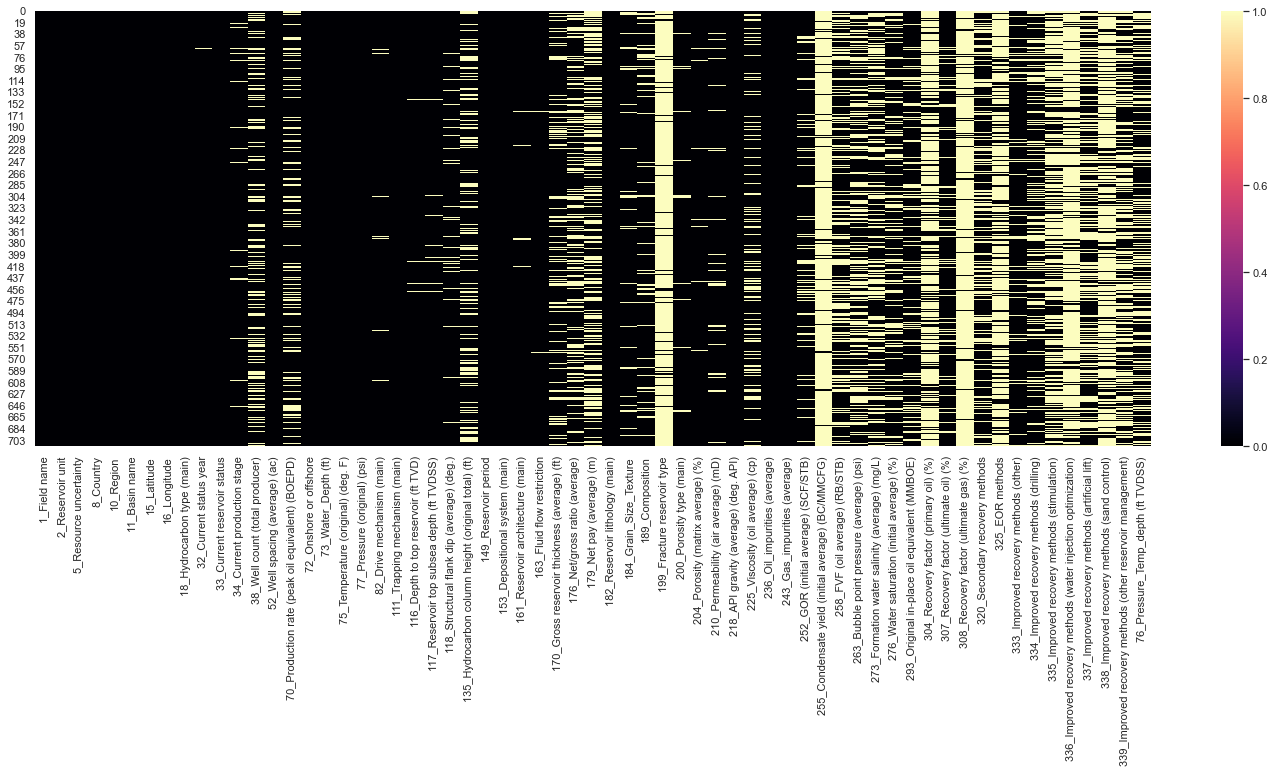

In [5]:
#Missing Values
fig, ax = plt.subplots(figsize=(25,8))
sns.heatmap(df.isnull(), ax=ax, cmap="magma")
plt.grid()
plt.show()

In [6]:
#Creating a base map
m = folium.Map()

for lat, lon, name in zip(df['15_Latitude'],df['16_Longitude'],df['1_Field name']):
    #Creating the marker
    folium.Marker(
    #Coordinate of the country
    location=[lat, lon],
    #The popup that show up if click the marker
    popup=name
    ).add_to(m)
m

In [7]:
print(df.shape)

(712, 63)


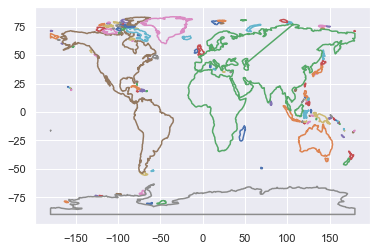

In [8]:
#%matplotlib inline
#import shapefile as shp  # Requires the pyshp package
#import matplotlib.pyplot as plt

sf = shp.Reader("ne_110m_land.shp")

plt.figure()
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y)
plt.show()

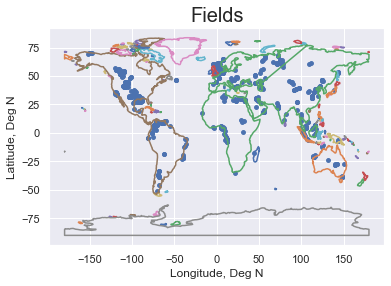

In [9]:
x = df['16_Longitude']
y = df['15_Latitude']

fig, ax = plt.subplots()
s = ax.scatter(x, y,
               color = 'b',
               s=15,
               marker='o')                   # Plot circles
               #alpha = 0.2 )
               
plt.title('Fields', fontsize = 20)
plt.ylabel('Latitude, Deg N')
plt.xlabel('Longitude, Deg N')

for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y)
plt.show()

##### Clean and Filter database for only Oil Reservoirs with Sandstone Lithology

In [10]:
#Clean and filter database for only Oil Reservoirs with Sandstone Lithology 
dfssoil = df.copy()

In [11]:
pd.set_option('display.max_rows', None)

In [12]:
#Null Values in Database
dfssoil.isnull().sum().sort_values(ascending=False)

255_Condensate yield (initial average) (BC/MMCFG)               667
199_Fracture reservoir type                                     660
308_Recovery factor (ultimate gas) (%)                          654
336_Improved recovery methods (water injection optimization)    579
338_Improved recovery methods (sand control)                    519
325_EOR methods                                                 512
304_Recovery factor (primary oil) (%)                           487
335_Improved recovery methods (stimulation)                     399
339_Improved recovery methods (other reservoir management)      328
179_Net pay (average) (m)                                       297
337_Improved recovery methods (artificial lift)                 273
273_Formation water salinity (average) (mg/L)                   263
263_Bubble point pressure (average) (psi)                       258
76_Pressure_Temp_depth (ft TVDSS)                               252
258_FVF (oil average) (RB/STB)                  

In [13]:
dfssoil.shape

(712, 63)

In [14]:
#Drop Drop Unnecessary Columns not related to oil reservoirs with sandstone lithology
dfssoil.drop(['255_Condensate yield (initial average) (BC/MMCFG)', '199_Fracture reservoir type', 
              '308_Recovery factor (ultimate gas) (%)', '273_Formation water salinity (average) (mg/L)', 
             '189_Composition', '184_Grain_Size_Texture', '163_Fluid flow restriction', '236_Oil_impurities (average)',
             '2_Reservoir unit', '111_Trapping mechanism (main)', '243_Gas_impurities (average)' ], axis=1, inplace=True)

In [15]:
#Check Drive Mechanism Column
print(dfssoil['82_Drive mechanism (main)'].value_counts())

AQUIFER DRIVE       366
GAS DRIVE           313
COMPACTION           13
GRAVITY DRAINAGE      7
Name: 82_Drive mechanism (main), dtype: int64


In [16]:
#print(dfssoil['320_Secondary recovery methods'].value_counts())
#print(dfssoil['325_EOR methods'].value_counts())
#print(dfssoil['333_Improved recovery methods (other)'].value_counts())
#print(dfssoil['334_Improved recovery methods (drilling)'].value_counts())
#print(dfssoil['335_Improved recovery methods (stimulation)'].value_counts())
#print(dfssoil['336_Improved recovery methods (water injection optimization)'].value_counts())
#print(dfssoil['337_Improved recovery methods (artificial lift)'].value_counts())
#print(dfssoil['338_Improved recovery methods (sand control)'].value_counts())
#print(dfssoil['339_Improved recovery methods (other reservoir management)'].value_counts())

In [17]:
# Collapse IOR EOR 
dfEORIOR = pd.DataFrame(dfssoil, columns=['320_Secondary recovery methods', '325_EOR methods', '333_Improved recovery methods (other)',
                                         '334_Improved recovery methods (drilling)','335_Improved recovery methods (stimulation)', 
                                          '336_Improved recovery methods (water injection optimization)', 
                                          '337_Improved recovery methods (artificial lift)', '338_Improved recovery methods (sand control)'
                                         '339_Improved recovery methods (other reservoir management)'])

In [18]:
dfEORIOR.head()

,320_Secondary recovery methods,325_EOR methods,333_Improved recovery methods (other),334_Improved recovery methods (drilling),335_Improved recovery methods (stimulation),336_Improved recovery methods (water injection optimization),337_Improved recovery methods (artificial lift),338_Improved recovery methods (sand control)339_Improved recovery methods (other reservoir management)
0,NaN,NaN,ARTIFICIAL LIFT,NaN,NaN,NaN,ROD PUMP,NaN
1,NaN,NaN,ARTIFICIAL LIFT,NaN,NaN,NaN,ROD PUMP,NaN
2,NaN,NaN,DRILLING/OTHER RESERVOIR MANAGEMENT,INFILL WELL,NaN,NaN,NaN,NaN
3,CONTINUOUS WATER INJECTION/GAS INJECTION/GAS R...,MISCIBLE,STIMULATION/WATER INJECTION OPTIMIZATION/SAND ...,NaN,HYDRAULIC FRACTURING (SINGLE STAGE),WATER INJECTION ON A ZONAL BASIS,NaN,NaN
4,GAS INJECTION,NaN,ARTIFICIAL LIFT,NaN,NaN,NaN,ESP/GAS LIFT,NaN


In [19]:
dfrf = pd.DataFrame(dfssoil, columns=['304_Recovery factor (primary oil) (%)', '307_Recovery factor (ultimate oil) (%)'])

In [20]:
print(dfrf.isnull().sum().sort_values(ascending=False))
dfrf.describe()

304_Recovery factor (primary oil) (%)     487
307_Recovery factor (ultimate oil) (%)     95
dtype: int64


,304_Recovery factor (primary oil) (%),307_Recovery factor (ultimate oil) (%)
count,225.000000,617.00000
mean,21.136489,38.95846
std,16.239014,15.32832
min,0.800000,4.00000
25%,10.000000,28.40000
50%,16.000000,39.00000
75%,27.000000,50.00000
max,76.000000,79.00000


In [21]:
dfssoil.isnull().sum().sort_values(ascending=False)

336_Improved recovery methods (water injection optimization)    579
338_Improved recovery methods (sand control)                    519
325_EOR methods                                                 512
304_Recovery factor (primary oil) (%)                           487
335_Improved recovery methods (stimulation)                     399
339_Improved recovery methods (other reservoir management)      328
179_Net pay (average) (m)                                       297
337_Improved recovery methods (artificial lift)                 273
263_Bubble point pressure (average) (psi)                       258
76_Pressure_Temp_depth (ft TVDSS)                               252
258_FVF (oil average) (RB/STB)                                  235
334_Improved recovery methods (drilling)                        217
320_Secondary recovery methods                                  204
176_Net/gross ratio (average)                                   195
38_Well count (total producer)                  

In [22]:
dfssoil['336a_Improved recovery methods (water injection optimization)'] = np.where(dfssoil['336_Improved recovery methods (water injection optimization)'].isnull(), 0, 1)
dfssoil['338a_Improved recovery methods (sand control)'] = np.where(dfssoil['338_Improved recovery methods (sand control)'].isnull(), 0, 1)
dfssoil['325a_EOR methods'] = np.where(dfssoil['325_EOR methods'].isnull(), 0, 1)
dfssoil['335a_Improved recovery methods (stimulation)'] = np.where(dfssoil['335_Improved recovery methods (stimulation)'].isnull(), 0, 1)
dfssoil['339a_Improved recovery methods (other reservoir management)'] = np.where(dfssoil['339_Improved recovery methods (other reservoir management)'].isnull(), 0, 1)
dfssoil['337a_Improved recovery methods (artificial lift)'] = np.where(dfssoil['337_Improved recovery methods (artificial lift)'].isnull(), 0, 1)
dfssoil['334a_Improved recovery methods (drilling)'] = np.where(dfssoil['334_Improved recovery methods (drilling)'].isnull(), 0, 1)
dfssoil['320a_Secondary recovery methods'] = np.where(dfssoil['320_Secondary recovery methods'].isnull(), 0, 1)
dfssoil['333a_Improved recovery methods (other)'] = np.where(dfssoil['333_Improved recovery methods (other)'].isnull(), 0, 1)

In [23]:
dfssoil.head()

,1_Field name,5_Resource uncertainty,8_Country,10_Region,11_Basin name,15_Latitude,16_Longitude,18_Hydrocarbon type (main),32_Current status year,33_Current reservoir status,...,76_Pressure_Temp_depth (ft TVDSS),336a_Improved recovery methods (water injection optimization),338a_Improved recovery methods (sand control),325a_EOR methods,335a_Improved recovery methods (stimulation),339a_Improved recovery methods (other reservoir management),337a_Improved recovery methods (artificial lift),334a_Improved recovery methods (drilling),320a_Secondary recovery methods,333a_Improved recovery methods (other)
0,ABU GHARADIG,1P,EGYPT,AFRICA,ABU GHARADIG,29.7422,28.4925,OIL,1998.0,PRIMARY RECOVERY,...,9350.0,0,0,0,0,0,1,0,0,1
1,ABU GHARADIG,1P,EGYPT,AFRICA,ABU GHARADIG,29.7422,28.4925,OIL,,PRIMARY RECOVERY,...,9650.0,0,0,0,0,0,1,0,0,1
2,AGBADA,1P,NIGERIA,AFRICA,NIGER DELTA,4.9326,6.9791,OIL,,PRIMARY RECOVERY,...,NaN,0,0,0,0,1,0,1,0,1
3,AGBAMI,1P,NIGERIA,AFRICA,NIGER DELTA,3.4000,6.5833,OIL,,ENHANCED OIL RECOVERY,...,NaN,1,1,1,1,1,0,0,1,1
4,AHWAZ,1P,IRAN,MIDDLE EAST,ZAGROS,31.2095,48.9490,OIL,2010.0,SECONDARY RECOVERY,...,NaN,0,0,0,0,0,1,0,1,1


In [24]:
#Drop duplicates
dfssoil.drop(['336_Improved recovery methods (water injection optimization)', 
              '338_Improved recovery methods (sand control)', '325_EOR methods', 
             '335_Improved recovery methods (stimulation)', '339_Improved recovery methods (other reservoir management)', '337_Improved recovery methods (artificial lift)', 
              '334_Improved recovery methods (drilling)', '320_Secondary recovery methods','333_Improved recovery methods (other)'], axis=1, inplace=True)

In [25]:
dfssoil['EORIOR'] = (dfssoil['336a_Improved recovery methods (water injection optimization)'] 
                     + dfssoil['338a_Improved recovery methods (sand control)'] + dfssoil['325a_EOR methods'] 
                     + dfssoil['335a_Improved recovery methods (stimulation)'] + dfssoil['339a_Improved recovery methods (other reservoir management)']
                     + dfssoil['337a_Improved recovery methods (artificial lift)']
                     + dfssoil['334a_Improved recovery methods (drilling)']
                     + dfssoil['320a_Secondary recovery methods'] + dfssoil['333a_Improved recovery methods (other)'])

In [26]:
dfssoil.drop(['336a_Improved recovery methods (water injection optimization)', 
              '338a_Improved recovery methods (sand control)', '325a_EOR methods', 
             '335a_Improved recovery methods (stimulation)', '339a_Improved recovery methods (other reservoir management)', '337a_Improved recovery methods (artificial lift)', 
              '334a_Improved recovery methods (drilling)', '320a_Secondary recovery methods', '333a_Improved recovery methods (other)'], axis=1, inplace=True)

In [27]:
dfssoil.shape

(712, 44)

In [28]:
dfssoil.isnull().sum().sort_values(ascending=False)

304_Recovery factor (primary oil) (%)                  487
179_Net pay (average) (m)                              297
263_Bubble point pressure (average) (psi)              258
76_Pressure_Temp_depth (ft TVDSS)                      252
258_FVF (oil average) (RB/STB)                         235
176_Net/gross ratio (average)                          195
38_Well count (total producer)                         181
135_Hydrocarbon column height (original total) (ft)    180
276_Water saturation (initial average) (%)             162
225_Viscosity (oil average) (cp)                       145
70_Production rate (peak oil equivalent) (BOEPD)       145
293_Original in-place oil equivalent (MMBOE)           133
170_Gross reservoir thickness (average) (ft)           126
307_Recovery factor (ultimate oil) (%)                  95
252_GOR (initial average) (SCF/STB)                     85
210_Permeability (air average) (mD)                     42
118_Structural flank dip (average) (deg.)               

In [29]:
# delete rows with no RF data
dfssoil = dfssoil.dropna(axis=0, subset=['307_Recovery factor (ultimate oil) (%)'])

In [30]:
# delete rows with no depth data
dfssoil = dfssoil.dropna(axis=0, subset=['117_Reservoir top subsea depth (ft TVDSS)'])

In [31]:
dfssoil.shape

(602, 44)

In [32]:
#Delete uncessary columns 
dfssoil.drop(['1_Field name', 
              '73_Water_Depth (ft)', 
             '33_Current reservoir status', '18_Hydrocarbon type (main)', '16_Longitude', 
              '5_Resource uncertainty', '8_Country', '15_Latitude'], axis=1, inplace=True)

dfssoil.drop(['70_Production rate (peak oil equivalent) (BOEPD)', 
              '34_Current production stage', 
             '200_Porosity type (main)'], axis=1, inplace=True)

dfssoil.drop(['76_Pressure_Temp_depth (ft TVDSS)'], axis=1, inplace=True)

dfssoil.drop([
    #'11_Basin name', 
              '32_Current status year', '304_Recovery factor (primary oil) (%)'], axis=1, inplace=True)

dfssoil.drop(['38_Well count (total producer)', 
              '258_FVF (oil average) (RB/STB)'], axis=1, inplace=True)

dfssoil.drop(['276_Water saturation (initial average) (%)', 
              '263_Bubble point pressure (average) (psi)','179_Net pay (average) (m)' ], axis=1, inplace=True)

dfssoil.drop(['135_Hydrocarbon column height (original total) (ft)', '182_Reservoir lithology (main)'], axis=1, inplace=True)

dfssoil.drop(['170_Gross reservoir thickness (average) (ft)'], axis=1, inplace=True)

dfssoil.drop(['116_Depth to top reservoir (ft TVD)'], axis=1, inplace=True)

#161_Reservoir architecture (main)
#116_Depth to top reservoir (ft TVD) 

In [33]:
dfssoil.shape

(602, 21)

In [34]:
# drop rows with no values for Drive Mechanism and Porosity 
dfssoil = dfssoil.dropna(axis=0, subset=['82_Drive mechanism (main)'])
dfssoil = dfssoil.dropna(axis=0, subset=['204_Porosity (matrix average) (%)'])

In [35]:
print(dfssoil['153_Depositional system (main)'].value_counts())

24:COASTAL        274
21:FLUVIAL        129
25:DEEP MARINE    108
23:LACUSTRINE      52
22:DESERT          18
26:GLACIOGENIC      4
Name: 153_Depositional system (main), dtype: int64


##### Generate values for missing permeability values as a function of porosity

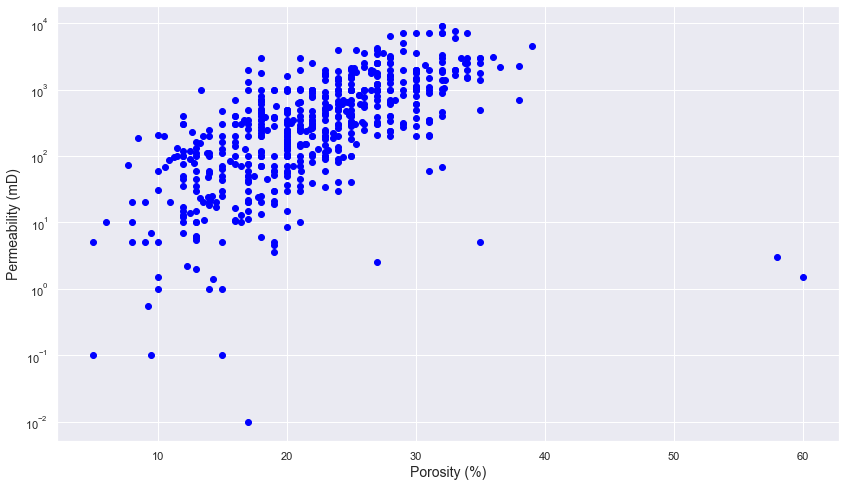

In [36]:
# Generate values for missing permeability values as a function of porosity
a = dfssoil['204_Porosity (matrix average) (%)']
b = dfssoil['210_Permeability (air average) (mD)']

plt.figure(figsize=(14, 8))
plt.scatter(a, b, color='blue')
plt.xlabel("Porosity (%)", size=14)
plt.ylabel("Permeability (mD)", size=14)
#plt.yscale('log', nonposy='clip')
plt.yscale('log')
#plt.gca().invert_yaxis()

#plt.tight_layout()
plt.show()

In [37]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
#fit = np.polyfit(np.log(x), y, 1)

# Start with Pressure
cdf = dfssoil[['210_Permeability (air average) (mD)', '204_Porosity (matrix average) (%)']]
testdf = cdf[cdf['210_Permeability (air average) (mD)'].isnull()==True].fillna(0)
traindf = cdf[cdf['210_Permeability (air average) (mD)'].isnull()==False].fillna(0)

y = traindf['210_Permeability (air average) (mD)']
traindf.drop('210_Permeability (air average) (mD)', axis=1, inplace=True)
ln_y = np.log(y)

lr.fit(traindf,ln_y)
testdf.drop('210_Permeability (air average) (mD)', axis=1, inplace=True)
#pred = lr.predict(testdf)
pred = np.exp(lr.predict(testdf))
testdf['210_Permeability (air average) (mD)'] = pred


#Coefficients
print("Gradient: ", lr.coef_)
print("Intercept: ", lr.intercept_)

testdf = testdf.rename(columns={'204_Porosity (matrix average) (%)': '204_RPT_Porosity (matrix average) (%)', 
                                '210_Permeability (air average) (mD)': '210_RPT_Permeability (air average) (mD)'
                               })

Gradient:  [0.16684684]
Intercept:  1.7982071518769778


In [38]:
dfssoil = pd.concat([dfssoil, testdf], axis=1)

In [39]:
dfssoil['210_Permeability (air average) (mD)'] = dfssoil['210_RPT_Permeability (air average) (mD)'].fillna(0) + dfssoil['210_Permeability (air average) (mD)'].fillna(0)

In [40]:
dfssoil = dfssoil.drop([
    '210_RPT_Permeability (air average) (mD)', '204_RPT_Porosity (matrix average) (%)', 
], axis = 1) 

##### Generate values for missing viscoisty values as a function of API

In [41]:
# Drop API gravity values more than 60 and 0 
#dfssoil['218_API gravity (average) (deg. API)'].hist()
#dfssoil['218_API gravity (average) (deg. API)'].value_counts(ascending=True)
dfssoil = dfssoil.drop(dfssoil[dfssoil['218_API gravity (average) (deg. API)'] > 60].index)
dfssoil = dfssoil.drop(dfssoil[dfssoil['218_API gravity (average) (deg. API)'] == 0].index)

<AxesSubplot:>

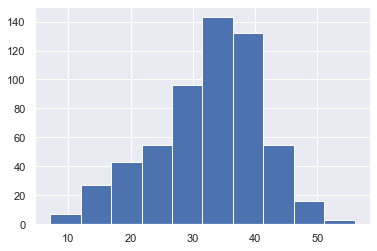

In [42]:
#dfssoil['218_API gravity (average) (deg. API)'].min()
dfssoil['218_API gravity (average) (deg. API)'].hist()

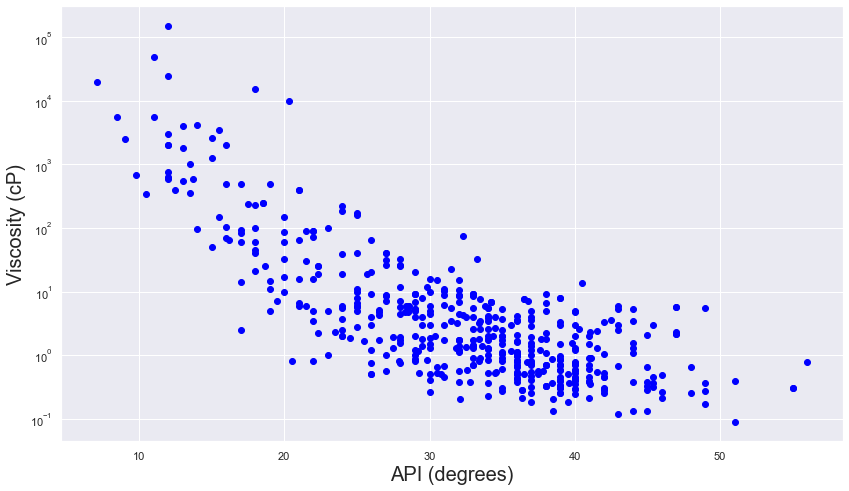

In [43]:
# Generate values for missing viscosity values as a function of API
a = dfssoil['218_API gravity (average) (deg. API)']
b = dfssoil['225_Viscosity (oil average) (cp)']

size = 20

plt.figure(figsize=(14, 8))
plt.scatter(a, b, color='blue')
plt.xlabel("API (degrees)", size=size)
plt.ylabel("Viscosity (cP)", size=size)
#plt.yscale('log', nonposy='clip')
plt.yscale('log')
#plt.gca().invert_yaxis()

#plt.tight_layout()
plt.show()

In [44]:
lr = LinearRegression()
#fit = np.polyfit(np.log(x), y, 1)

# Start with Pressure
cdf2 = dfssoil[['225_Viscosity (oil average) (cp)', '218_API gravity (average) (deg. API)']]
testdf2 = cdf2[cdf2['225_Viscosity (oil average) (cp)'].isnull()==True].fillna(0)
traindf2 = cdf2[cdf2['225_Viscosity (oil average) (cp)'].isnull()==False].fillna(0)

y2 = traindf2['225_Viscosity (oil average) (cp)']
traindf2.drop('225_Viscosity (oil average) (cp)', axis=1, inplace=True)
ln_y2 = np.log(y2)

lr.fit(traindf2,ln_y2)
testdf2.drop('225_Viscosity (oil average) (cp)', axis=1, inplace=True)
#pred = lr.predict(testdf)
pred2 = np.exp(lr.predict(testdf2))
testdf2['225_Viscosity (oil average) (cp)'] = pred2


#Coefficients
print("Gradient: ", lr.coef_)
print("Intercept: ", lr.intercept_)

testdf2 = testdf2.rename(columns={'218_API gravity (average) (deg. API)': '218_RPT_API gravity (average) (deg. API)', 
                                '225_Viscosity (oil average) (cp)': '225_RPT_Viscosity (oil average) (cp)'
                               })

Gradient:  [-0.20583617]
Intercept:  7.88112501379032


In [45]:
dfssoil = pd.concat([dfssoil, testdf2], axis=1)

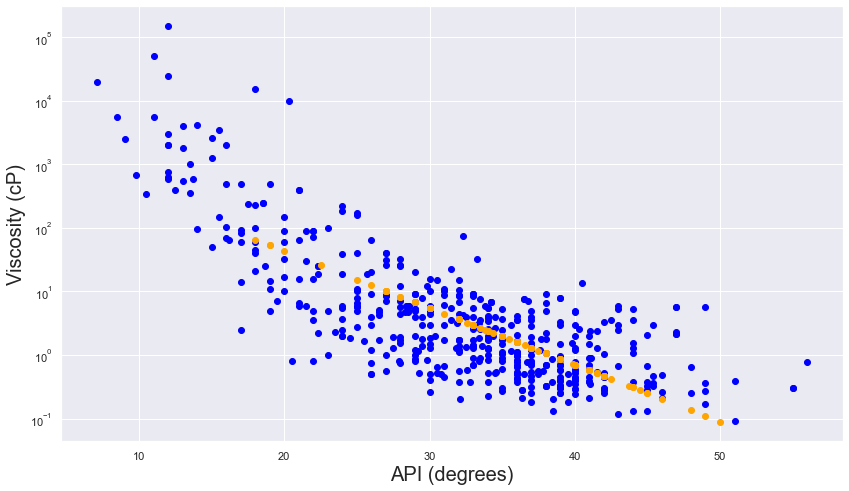

In [47]:
# Generate values for missing permeability values as a function of porosity
a = dfssoil['218_API gravity (average) (deg. API)']
b = dfssoil['225_Viscosity (oil average) (cp)']

b1 = dfssoil['225_RPT_Viscosity (oil average) (cp)']

size = 20

plt.figure(figsize=(14, 8))
plt.scatter(a, b, color='blue')
plt.scatter(a, b1, color='orange')
plt.xlabel("API (degrees)", size=size)
plt.ylabel("Viscosity (cP)", size=size)
#plt.yscale('log', nonposy='clip')
plt.yscale('log')
#plt.gca().invert_yaxis()

#plt.tight_layout()
plt.show()

In [48]:
dfssoil['225_Viscosity (oil average) (cp)'] = dfssoil['225_RPT_Viscosity (oil average) (cp)'].fillna(0) + dfssoil['225_Viscosity (oil average) (cp)'].fillna(0)

dfssoil = dfssoil.drop([
    '225_RPT_Viscosity (oil average) (cp)', '218_RPT_API gravity (average) (deg. API)', 
], axis = 1) 

In [49]:
dfssoil.shape

(577, 21)

In [50]:
dfssoil.isnull().sum().sort_values(ascending=False)

176_Net/gross ratio (average)                   141
293_Original in-place oil equivalent (MMBOE)     62
252_GOR (initial average) (SCF/STB)              54
118_Structural flank dip (average) (deg.)        16
161_Reservoir architecture (main)                 6
10_Region                                         0
307_Recovery factor (ultimate oil) (%)            0
225_Viscosity (oil average) (cp)                  0
218_API gravity (average) (deg. API)              0
210_Permeability (air average) (mD)               0
204_Porosity (matrix average) (%)                 0
153_Depositional system (main)                    0
11_Basin name                                     0
149_Reservoir period                              0
117_Reservoir top subsea depth (ft TVDSS)         0
82_Drive mechanism (main)                         0
77_Pressure (original) (psi)                      0
75_Temperature (original) (deg. F)                0
72_Onshore or offshore                            0
52_Well spac

##### Generate values for missing GOR values as a function of Pressure

<Figure size 1440x1080 with 0 Axes>

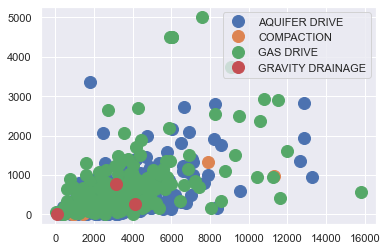

In [51]:
# Check if Drive mechanism impacts GOR
groups = dfssoil.groupby('82_Drive mechanism (main)')
plt.figure(figsize=(20, 15))
fig, ax = plt.subplots()
#ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group['77_Pressure (original) (psi)'], group['252_GOR (initial average) (SCF/STB)'], marker='o', linestyle='', ms=12, label=name)
ax.legend()


plt.show()

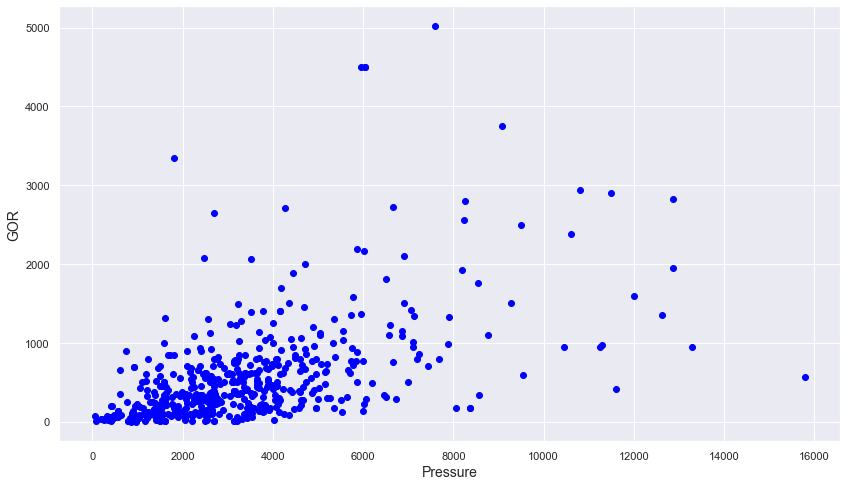

In [52]:
# Generate values for missing GOR values as a function of Pressure
a = dfssoil['77_Pressure (original) (psi)']
b = dfssoil['252_GOR (initial average) (SCF/STB)']

plt.figure(figsize=(14, 8))
plt.scatter(a, b, color='blue')
plt.xlabel("Pressure", size=14)
plt.ylabel("GOR", size=14)
#plt.yscale('log')
#plt.xscale('log')
#plt.gca().invert_yaxis()

#plt.tight_layout()
plt.show()

In [53]:
lr = LinearRegression()
#fit = np.polyfit(np.log(x), y, 1)

# Start with Pressure
cdf3 = dfssoil[['252_GOR (initial average) (SCF/STB)', '77_Pressure (original) (psi)']]
testdf3 = cdf3[cdf3['252_GOR (initial average) (SCF/STB)'].isnull()==True].fillna(0)
traindf3 = cdf3[cdf3['252_GOR (initial average) (SCF/STB)'].isnull()==False].fillna(0)

y3 = traindf3['252_GOR (initial average) (SCF/STB)']
traindf3.drop('252_GOR (initial average) (SCF/STB)', axis=1, inplace=True)
#ln_y2 = np.log(y2)

lr.fit(traindf3,y3)
testdf3.drop('252_GOR (initial average) (SCF/STB)', axis=1, inplace=True)
pred = lr.predict(testdf3)
#pred2 = np.exp(lr.predict(testdf2))
testdf3['252_GOR (initial average) (SCF/STB)'] = pred


#Coefficients
print("Gradient: ", lr.coef_)
print("Intercept: ", lr.intercept_)

testdf3 = testdf3.rename(columns={'77_Pressure (original) (psi)': '77_RPT_Pressure (original) (psi)', 
                                '252_GOR (initial average) (SCF/STB)': '252_RPT_GOR (initial average) (SCF/STB)'
                               })

Gradient:  [0.14838594]
Intercept:  61.016691040063506


In [54]:
dfssoil = pd.concat([dfssoil, testdf3], axis=1)

dfssoil['252_GOR (initial average) (SCF/STB)'] = dfssoil['252_RPT_GOR (initial average) (SCF/STB)'].fillna(0) + dfssoil['252_GOR (initial average) (SCF/STB)'].fillna(0)

dfssoil = dfssoil.drop([
    '252_RPT_GOR (initial average) (SCF/STB)', '77_RPT_Pressure (original) (psi)', 
], axis = 1) 

##### Generate values for missing STOIIP values as a function of Porosity

<Figure size 1440x1080 with 0 Axes>

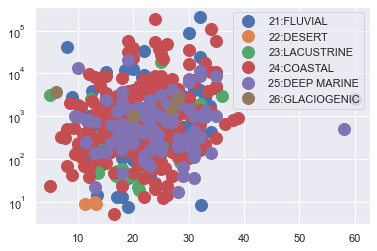

In [55]:
# Check if lithology impacts STOIIP
groups = dfssoil.groupby('153_Depositional system (main)')
plt.figure(figsize=(20, 15))
fig, ax = plt.subplots()
#ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group['204_Porosity (matrix average) (%)'], group['293_Original in-place oil equivalent (MMBOE)'], marker='o', linestyle='', ms=12, label=name)
ax.legend()
ax.set_yscale("log")

plt.show()

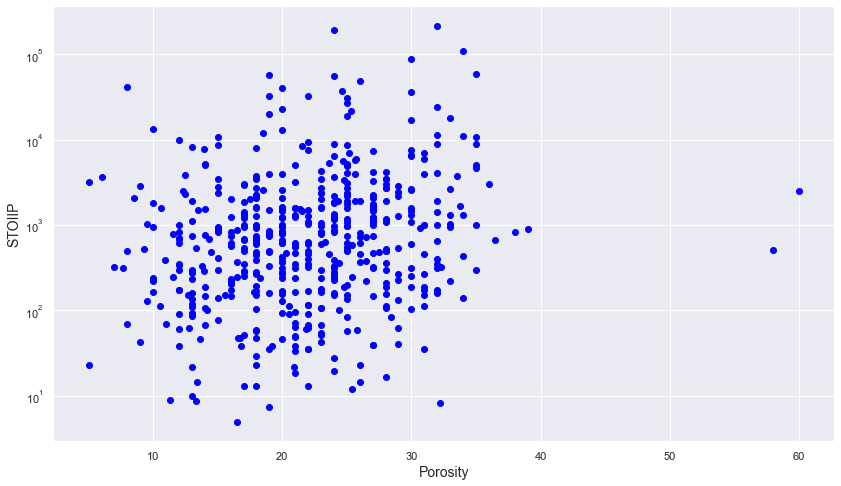

In [56]:
# Generate values for missing STOIIP values as a function of Porosity
a = dfssoil['204_Porosity (matrix average) (%)']
b = dfssoil['293_Original in-place oil equivalent (MMBOE)']

plt.figure(figsize=(14, 8))
plt.scatter(a, b, color='blue')
plt.xlabel("Porosity", size=14)
plt.ylabel("STOIIP", size=14)
plt.yscale('log')
#plt.xscale('log')
#plt.gca().invert_yaxis()

#plt.tight_layout()
plt.show()

In [57]:
lr = LinearRegression()
#fit = np.polyfit(np.log(x), y, 1)

# Start with Pressure
cdf4 = dfssoil[['293_Original in-place oil equivalent (MMBOE)', '204_Porosity (matrix average) (%)']]
testdf4 = cdf4[cdf4['293_Original in-place oil equivalent (MMBOE)'].isnull()==True].fillna(0)
traindf4 = cdf4[cdf4['293_Original in-place oil equivalent (MMBOE)'].isnull()==False].fillna(0)

y4 = traindf4['293_Original in-place oil equivalent (MMBOE)']
traindf4.drop('293_Original in-place oil equivalent (MMBOE)', axis=1, inplace=True)
ln_y4 = np.log(y4)

lr.fit(traindf4,y4)
testdf4.drop('293_Original in-place oil equivalent (MMBOE)', axis=1, inplace=True)
pred = lr.predict(testdf4)
#pred2 = np.exp(lr.predict(testdf2))
testdf4['293_Original in-place oil equivalent (MMBOE)'] = pred


#Coefficients
print("Gradient: ", lr.coef_)
print("Intercept: ", lr.intercept_)

testdf4 = testdf4.rename(columns={'204_Porosity (matrix average) (%)': '204_RPT_Porosity (matrix average) (%)', 
                                '293_Original in-place oil equivalent (MMBOE)': '293_RPT_Original in-place oil equivalent (MMBOE)'
                               })

Gradient:  [272.03741375]
Intercept:  -2201.2887324719504


In [58]:
dfssoil = pd.concat([dfssoil, testdf4], axis=1)

dfssoil['293_Original in-place oil equivalent (MMBOE)'] = dfssoil['293_Original in-place oil equivalent (MMBOE)'].fillna(0) + dfssoil['293_RPT_Original in-place oil equivalent (MMBOE)'].fillna(0)

dfssoil = dfssoil.drop([
    '293_RPT_Original in-place oil equivalent (MMBOE)', '204_RPT_Porosity (matrix average) (%)', 
], axis = 1) 

##### Drop rows without NTG since no correlation can be found between NTG and Porosity 

<Figure size 1440x1080 with 0 Axes>

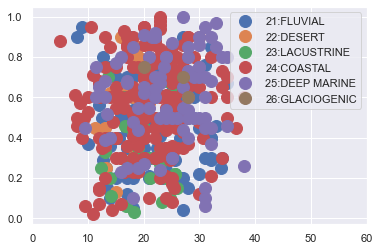

In [59]:
# Check if lithology impacts NTG
groups = dfssoil.groupby('153_Depositional system (main)')
plt.figure(figsize=(20, 15))
fig, ax = plt.subplots()
#ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group['204_Porosity (matrix average) (%)'], group['176_Net/gross ratio (average)'], marker='o', linestyle='', ms=12, label=name)
ax.legend()
#'210_Permeability (air average) (mD)'
#ax.set_yscale("log")
#ax.set_xscale("log")
ax.set_xlim(xmin=0.0, xmax=60)

plt.show()

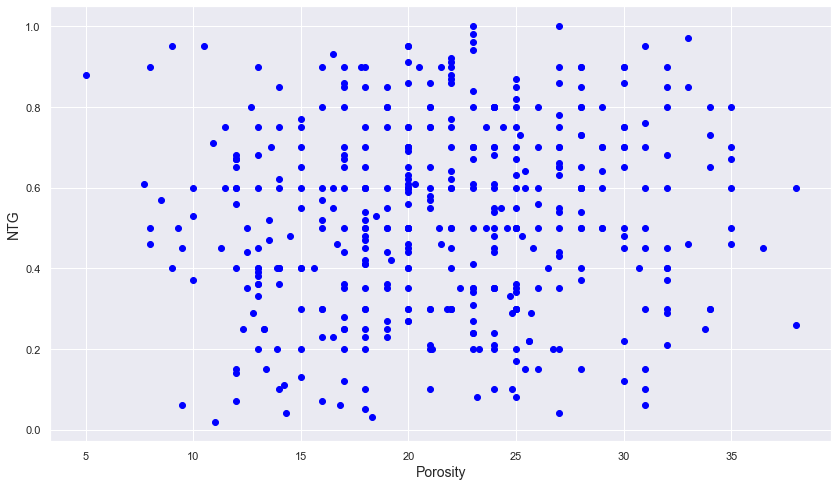

In [60]:
# Generate values for missing STOIIP values as a function of Porosity
a = dfssoil['204_Porosity (matrix average) (%)']
b = dfssoil['176_Net/gross ratio (average)']

plt.figure(figsize=(14, 8))
plt.scatter(a, b, color='blue')
plt.xlabel("Porosity", size=14)
plt.ylabel("NTG", size=14)
#plt.yscale('log')
#|plt.xscale('log')
#plt.gca().invert_yaxis()

#plt.tight_layout()
plt.show()

In [61]:
dfssoil = dfssoil.dropna(axis=0, subset=['176_Net/gross ratio (average)'])

##### Fill missing values for Structural Flank Dip with average

In [62]:
#fill missing values for Structural Flank Dip with average
#dfssoil['118_Structural flank dip (average) (deg.)'] = dfssoil['118_Structural flank dip (average) (deg.)'].apply(lambda x: x.fillna(x.mean().iat[0]))

mean_flankdip=dfssoil['118_Structural flank dip (average) (deg.)'].mean()
dfssoil['118_Structural flank dip (average) (deg.)'].fillna(value=mean_flankdip, inplace=True)

In [63]:
#dfssoil = dfssoil.dropna(axis=0, subset=['118_Structural flank dip (average) (deg.)'])

##### Fill missing reservoir architecture with mode

In [64]:
print(dfssoil['161_Reservoir architecture (main)'].value_counts())

LAYER-CAKE                  257
JIGSAW-PUZZLE               132
LABYRINTH                    29
TANK LIKE                     9
LAYER-CAKE/TANK LIKE          2
JIGSAW-PUZZLE/LAYER-CAKE      2
JIGSAW-PUZZLE/LABYRINTH       1
Name: 161_Reservoir architecture (main), dtype: int64


In [65]:
#dfssoil["161_Reservoir architecture (main)"] = dfssoil.apply(lambda x: x.fillna(x.mode().iat[0]))
dfssoil['161_Reservoir architecture (main)'] = dfssoil['161_Reservoir architecture (main)'].fillna(dfssoil['161_Reservoir architecture (main)'].mode()[0])

In [66]:
dfssoil.isnull().sum().sort_values(ascending=False)

10_Region                                       0
161_Reservoir architecture (main)               0
307_Recovery factor (ultimate oil) (%)          0
293_Original in-place oil equivalent (MMBOE)    0
252_GOR (initial average) (SCF/STB)             0
225_Viscosity (oil average) (cp)                0
218_API gravity (average) (deg. API)            0
210_Permeability (air average) (mD)             0
204_Porosity (matrix average) (%)               0
176_Net/gross ratio (average)                   0
153_Depositional system (main)                  0
11_Basin name                                   0
149_Reservoir period                            0
118_Structural flank dip (average) (deg.)       0
117_Reservoir top subsea depth (ft TVDSS)       0
82_Drive mechanism (main)                       0
77_Pressure (original) (psi)                    0
75_Temperature (original) (deg. F)              0
72_Onshore or offshore                          0
52_Well spacing (average) (ac)                  0


In [67]:
dfssoil.shape

(436, 21)

In [68]:
dfssoil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 436 entries, 0 to 710
Data columns (total 21 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   10_Region                                     436 non-null    object 
 1   11_Basin name                                 436 non-null    object 
 2   52_Well spacing (average) (ac)                436 non-null    float64
 3   72_Onshore or offshore                        436 non-null    object 
 4   75_Temperature (original) (deg. F)            436 non-null    float64
 5   77_Pressure (original) (psi)                  436 non-null    float64
 6   82_Drive mechanism (main)                     436 non-null    object 
 7   117_Reservoir top subsea depth (ft TVDSS)     436 non-null    float64
 8   118_Structural flank dip (average) (deg.)     436 non-null    float64
 9   149_Reservoir period                          436 non-null    obj

<AxesSubplot:>

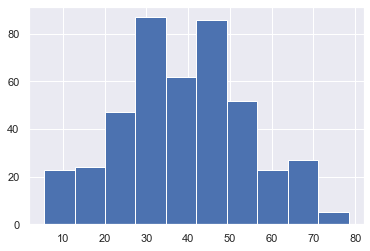

In [69]:
dfssoil['307_Recovery factor (ultimate oil) (%)'].hist()

In [70]:
print(dfssoil['149_Reservoir period'].value_counts())

CRETACEOUS                                124
NEOGENE                                    98
PALEOGENE                                  77
JURASSIC                                   53
TRIASSIC                                   12
NEOGENE/PALEOGENE                          12
PERMIAN                                     9
CARBONIFEROUS                               9
PERMIAN/CARBONIFEROUS                       7
JURASSIC/TRIASSIC                           7
DEVONIAN                                    7
ORDOVICIAN/CAMBRIAN                         4
CAMBRIAN                                    3
TRIASSIC/CARBONIFEROUS                      2
PROTEROZOIC                                 2
CRETACEOUS/JURASSIC                         2
PALEOGENE/CRETACEOUS                        2
CRETACEOUS/TRIASSIC/PALEOZOIC               1
CAMBRIAN/PROTEROZOIC                        1
CRETACEOUS/PALEOZOIC                        1
NEOGENE/PALEOGENE/CRETACEOUS                1
CRETACEOUS/JURASSIC/TRIASSIC/PALEO

In [71]:
dfssoil.to_excel(r'dfssoil_ori.xlsx', index = False, header=True)

### Train, Validation, and Test Split

In [72]:
# Creates a mask where values that are true go into the training/test set
# Note that I done it so that the random number is predictable

msk = np.random.seed(0)
msk = np.random.rand(len(dfssoil))<0.8

raw_train_validate_set = dfssoil[msk]
raw_test_set = dfssoil[~msk]

print(raw_train_validate_set.shape)
print(raw_test_set.shape)

(356, 21)
(80, 21)


In [ ]:
raw_train_validate_set.to_excel(r'dfssoil.xlsx', index = False, header=True)
raw_train_validate_set.to_excel(r'dfssoil.xlsx', index = False, header=True)